1. Write a query to find the average salary both yearly (salary_year_avg) and hourly (salary_hour_avg) for job postings that were posted after June 1, 2023. Group the results by job schedule type.

In [ ]:
SELECT
    AVG(salary_year_avg) AS salary_year_avg,
    AVG(salary_hour_avg) AS salary_hour_avg,
    job_schedule_type
FROM job_postings_fact
WHERE job_posted_date > '2023-06-01'
    AND (salary_year_avg IS NOT NULL
    OR salary_hour_avg IS NOT NULL)
GROUP BY job_schedule_type
;

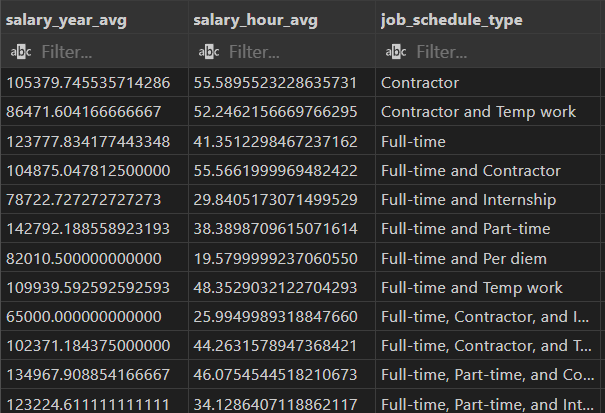

2. Write a query to count the number of job postings for each month in 2023, adjusting (hint) the month. Group by and order by the month.

In [ ]:
SELECT
    COUNT(job_id) AS job_posted_count,
    EXTRACT(MONTH FROM job_posted_date) AS month
FROM
    job_postings_fact
WHERE job_posted_date BETWEEN '2023-01-01' AND '2023-12-31'
GROUP BY month
ORDER BY month;

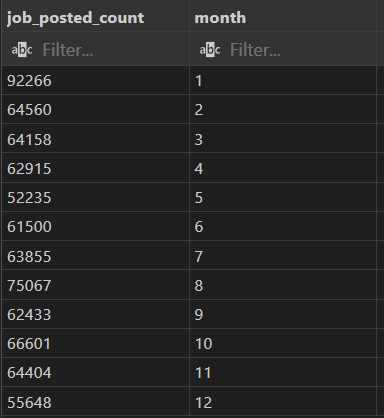

3. Write a query to find companies (include company name) that have posted jobs offering health insurance, where these postings were made in the second quarter of 2023. Use date extraction to filter by quarter.

In [ ]:
SELECT
    cd.name AS company_name,
    EXTRACT(YEAR FROM job_posted_date) AS year,
    EXTRACT(QUARTER FROM job_posted_date) AS quarter,
    jpf.job_health_insurance
FROM
    job_postings_fact jpf
INNER JOIN company_dim cd
    ON jpf.company_id = cd.company_id
WHERE job_health_insurance IS TRUE
GROUP BY 1,2,3,4
HAVING EXTRACT(YEAR FROM job_posted_date) = 2023
    AND EXTRACT(QUARTER FROM job_posted_date) = 2
ORDER BY 1
;

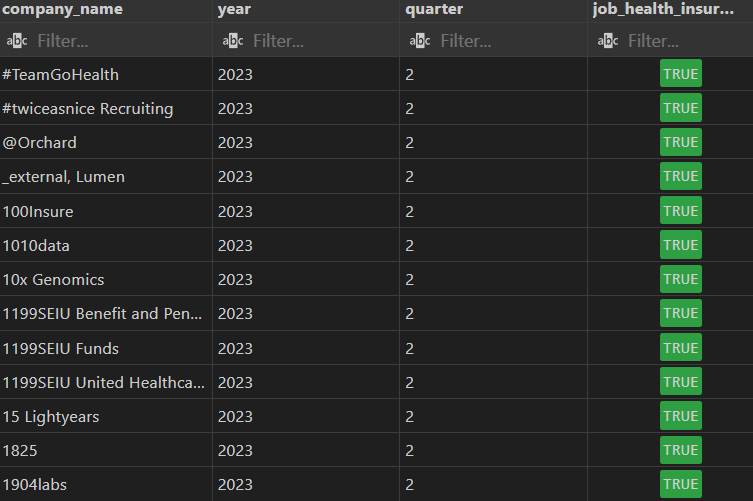